In [1]:
import numpy as np
import keras
import scipy

import matplotlib.pyplot as plt
%matplotlib inline

from keras_tqdm import TQDMNotebookCallback
from keras.models import model_from_json

from random import randint
from random import seed
from numpy import array
from numpy import argmax
from numpy import array_equal
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense

import myencdecfuncs as my

Using TensorFlow backend.


In [2]:
temp = np.arange(30).reshape(3,10)
print(temp[:,:-1])

[[ 0  1  2  3  4  5  6  7  8]
 [10 11 12 13 14 15 16 17 18]
 [20 21 22 23 24 25 26 27 28]]


In [3]:
#####For Demo
tempunsorted, temppadded, temptarget = my.quickCreate(2,3)
#print(tempunsorted, "\n\n---------\n\n", temppadded, "\n\n---------\n\n", temptarget)
print(tempunsorted.shape, temppadded.shape, temptarget.shape)
tu = tempunsorted[0].reshape(10, 10)
tt = temptarget[0].reshape(10, 10)
print("\n\n", tu, "\n\n", tt)

flatvec:  (2, 100) 2
(2, 100) (2, 100) (2, 100)


 [[35 22 25 16 31  6 27  9 28  2]
 [12  4 19 27 21 24 13  3 27 22]
 [17  3 29 20 12 35 23  6 25 32]
 [18  7 13  6 33 10 22  3 12 26]
 [17 19 22 32 33  3 10 34  4 35]
 [35 34 19 32 25 31  4 10  5 22]
 [ 1 14 34 15 16 19  1 23 35 24]
 [28  7 10 32 11  8 32  8 35 25]
 [ 4 10 30 33 14 35 14 28 18  3]
 [26 13 11 15 28 23 15 28 12 35]] 

 [[ 1 14 34 15 16 19  1 23 35 24]
 [ 4 10 30 33 14 35 14 28 18  3]
 [12  4 19 27 21 24 13  3 27 22]
 [17 19 22 32 33  3 10 34  4 35]
 [17  3 29 20 12 35 23  6 25 32]
 [18  7 13  6 33 10 22  3 12 26]
 [26 13 11 15 28 23 15 28 12 35]
 [28  7 10 32 11  8 32  8 35 25]
 [35 34 19 32 25 31  4 10  5 22]
 [35 22 25 16 31  6 27  9 28  2]]


In [4]:
#36, 36, 128
def buildModels(encin, decin, outnum, hiddenUnits):
    #some quick math
    #if the arrays are the same, I'm putting the padval at start and end of the input arrays
    if (encin == outnum):
        encin += 1
        decin += 1
        outnum += 1
   #this is the training model 
    #build training encoder
    encoder_inputs = keras.layers.Input(shape=(None, encin))
    encoder = keras.layers.LSTM(hiddenUnits, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    encoder_states = [state_h, state_c]
    #build training decoder
    decoder_inputs = keras.layers.Input(shape=(None, decin))
    decoder_lstm = keras.layers.LSTM(hiddenUnits, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_dense = keras.layers.Dense(outnum, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)
    fmodel = keras.models.Model([encoder_inputs, decoder_inputs], decoder_outputs)
    
   #these are the separate inference models 
    #build inference encoder
    encoder_model = keras.models.Model(encoder_inputs, encoder_states)
    #build inference decoder
    decoder_state_input_h = keras.layers.Input(shape=(hiddenUnits,))
    decoder_state_input_c = keras.layers.Input(shape=(hiddenUnits,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = keras.models.Model([decoder_inputs] + decoder_states_inputs, 
                                       [decoder_outputs] + decoder_states)
    
    return fmodel, encoder_model, decoder_model

print("Function Created!")

Function Created!


In [5]:
#target = predict_sequence(encoder, decoder, X1, n_steps_out, n_features)
#run the network without teacher-forcing
def testNetwork(encoder, decoder, insequence, length, cardinality):
    #encode the input sequence
    state = encoder.predict(insequence)
    #initializing array for the "input" to the decoder
    decoder_prediction = np.zeros(shape=(1, 1, cardinality), dtype=float)
    
    #cycle through individual predictions
    output = [] 
    for _ in range(length):
        #predict next item
        decout, h, c = decoder.predict([decoder_prediction] + state)
        #store prediction
        output.append(decout[0,0,:])
        #update state
        state = [h, c]
        decoder_prediction = decout
    return array(output)


print("Function Created!")

Function Created!


In [6]:
#set relevant values
#unlike previous parts, the input should be a flattened 2D matrix
features = 36 #default value
rows = 10
cols = 10
num_inputs = rows * cols
num_matrices = 100
hiddenUnits = 256 #not sure why this value (128*2)
n_samples = 110 #original 100000
startval = 1 #default value is 1
padval = 0 #default value is 0

#build, compile, and summarize the model
model, encoder, decoder = buildModels(features, features, features, hiddenUnits)
model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.categorical_crossentropy, 
              metrics=['accuracy'])
model.summary()

# generate training dataset

#my function uses default values for the input vector length (10), starting and ending values (1,36)
#padding value (0), and the cardinality or number of classes (37)
#the input values are the number of vectors (n_samples) and which function is used.
#function 1 build training data for a simple row-by-row sort, function 2 uses the LNS task
#and function 3 sorts only the first column of the matrix. 
in1, in2, out = my.quickBuild(n_samples, 3)
print("The enc input, dec input, and output shapes: ", in1.shape, in2.shape, out.shape)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 37)     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 37)     0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 256), (None, 301056      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 256),  301056      input_2[0][0]                    
                                                                 lstm_1[0][1]               

In [7]:
# train model
myepochs = 10
batch_size = 1
history = model.fit([in1, in2], out, epochs=myepochs, batch_size = batch_size, verbose=0, validation_split=0.2,
                   callbacks=[TQDMNotebookCallback()])

print('Accuracy:', model.evaluate([in1, in2], out)[1]*100.0,'%')


110/110 [==============================] - 1s 6ms/step
Accuracy: 7.027272880077362 %


In [8]:
#test encoder decoder model
total, correct = 100, 0
cardinality = features + 1
length = 10

#to get an accuracy check, test 100 sequences of 10 samples
for _ in range(total):
    #build 100 test sequences
    testin1, testin2, testout = my.quickBuild(1,1)
    #for each sample (1Darray)...
    target = testNetwork(encoder, decoder, testin1, length, cardinality)
    if array_equal(my.OHdecode(testout[0]), my.OHdecode(target)):
        correct += 1

print('Accuracy: %.2f%%' % (float(correct)/float(total)*100.0))


#spot check some examples
for _ in range(10):
    X1, X2, y = my.quickBuild(1,1)
    target = testNetwork(encoder, decoder, X1, length, cardinality)
    print('Input=%s Target=%s, Output=%s' % (my.OHdecode(X1[0]), my.OHdecode(y[0]), my.OHdecode(target)))

Accuracy: 0.00%
Input=[23, 18, 4, 22, 4, 32, 21, 15, 15, 11] Target=[4, 4, 11, 15, 15, 18, 21, 22, 23, 32], Output=[1, 14, 9, 9, 16, 16, 4, 4, 4, 4]
Input=[13, 7, 8, 22, 33, 21, 3, 19, 12, 13] Target=[3, 7, 8, 12, 13, 13, 19, 21, 22, 33], Output=[2, 14, 9, 9, 16, 16, 4, 4, 4, 4]
Input=[31, 13, 34, 35, 1, 16, 14, 14, 8, 6] Target=[1, 6, 8, 13, 14, 14, 16, 31, 34, 35], Output=[2, 14, 9, 9, 16, 16, 4, 4, 4, 4]
Input=[20, 28, 6, 13, 1, 6, 4, 32, 8, 15] Target=[1, 4, 6, 6, 8, 13, 15, 20, 28, 32], Output=[1, 14, 9, 9, 16, 16, 4, 4, 4, 4]
Input=[29, 14, 28, 4, 15, 28, 28, 19, 14, 33] Target=[4, 14, 14, 15, 19, 28, 28, 28, 29, 33], Output=[2, 14, 9, 9, 11, 16, 4, 4, 4, 4]
Input=[28, 8, 14, 6, 22, 17, 31, 20, 4, 14] Target=[4, 6, 8, 14, 14, 17, 20, 22, 28, 31], Output=[2, 14, 9, 9, 16, 16, 4, 4, 4, 4]
Input=[12, 21, 13, 12, 6, 10, 4, 13, 3, 20] Target=[3, 4, 6, 10, 12, 12, 13, 13, 20, 21], Output=[1, 14, 9, 9, 16, 16, 4, 4, 4, 4]
Input=[11, 31, 18, 34, 8, 27, 23, 12, 20, 27] Target=[8, 11, 12, 

In [9]:
#test encoder decoder model
total, correct = 100, 0
cardinality = features + 1
length = 10

#to get an accuracy check, test 100 sequences of 10 samples
for _ in range(total):
    #build 100 test sequences
    testin1, testin2, testout = my.quickBuild(1,1)
    #for each sample (1Darray)...
    target = testNetwork(encoder, decoder, testin1, length, cardinality)
    if array_equal(my.OHdecode(testout[0]), my.OHdecode(target)):
        correct += 1

print('Accuracy: %.2f%%' % (float(correct)/float(total)*100.0))


#spot check some examples
for _ in range(10):
    X1, X2, y = my.quickBuild(1,1)
    target = testNetwork(encoder, decoder, X1, length, cardinality)
    print('Input=%s Target=%s, Output=%s' % (my.OHdecode(X1[0]), my.OHdecode(y[0]), my.OHdecode(target)))

Accuracy: 0.00%
Input=[25, 12, 21, 30, 6, 5, 14, 28, 27, 27] Target=[5, 6, 12, 14, 21, 25, 27, 27, 28, 30], Output=[2, 14, 9, 9, 16, 16, 4, 4, 4, 4]
Input=[31, 17, 2, 32, 1, 8, 24, 19, 12, 27] Target=[1, 2, 8, 12, 17, 19, 24, 27, 31, 32], Output=[1, 14, 9, 9, 16, 16, 4, 4, 4, 4]
Input=[35, 6, 31, 30, 2, 10, 3, 1, 16, 21] Target=[1, 2, 3, 6, 10, 16, 21, 30, 31, 35], Output=[1, 14, 9, 9, 16, 16, 4, 4, 4, 4]
Input=[27, 19, 17, 5, 10, 17, 35, 19, 28, 12] Target=[5, 10, 12, 17, 17, 19, 19, 27, 28, 35], Output=[1, 14, 9, 9, 9, 16, 4, 4, 4, 4]
Input=[10, 22, 29, 27, 10, 31, 12, 15, 28, 32] Target=[10, 10, 12, 15, 22, 27, 28, 29, 31, 32], Output=[1, 14, 9, 9, 11, 16, 4, 4, 4, 4]
Input=[19, 11, 12, 11, 7, 22, 9, 35, 27, 13] Target=[7, 9, 11, 11, 12, 13, 19, 22, 27, 35], Output=[2, 14, 9, 9, 16, 16, 4, 4, 4, 4]
Input=[2, 15, 28, 31, 25, 16, 10, 21, 11, 29] Target=[2, 10, 11, 15, 16, 21, 25, 28, 29, 31], Output=[1, 14, 9, 9, 16, 16, 4, 4, 4, 4]
Input=[19, 5, 19, 13, 35, 23, 19, 25, 27, 1] Target=

In [10]:
#model_json = model.to_json()
#with open('3rdModel99pc.json', 'w') as json_file:
#    json_file.write(model_json)
#
#model.save_weights("3rdModel99pc.h5")
#print("Saved Model to Disk")

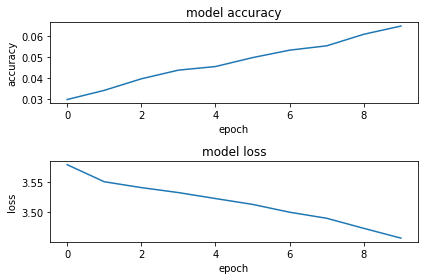

In [11]:
plt.figure(1)
#summarize history for accuracy
plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
#summarize history for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.tight_layout()
plt.show()